In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as vdatasets
import torchvision.utils as vutils
import torchvision.models as vmodels
import torchvision
import random
from PIL import Image
import json
import Augmentor
import os
torch.manual_seed(1)

DATA_PATH = os.environ['DATA_PATH']
USE_CUDA = torch.cuda.is_available()

http://cs231n.github.io/transfer-learning/

## Load Pretrained model 

In [2]:
model = vmodels.vgg16(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size=(3, 3), 

## 이미지넷 클래스 메타 정보 

이미지넷 대회에서 사용한 1000개의 클래스에 관한 사전 정보

In [3]:
idx2cls = json.load(open('imagenet_class.json','r',encoding='utf-8'))

In [4]:
list(idx2cls.items())[:10]

[('612', 'jinrikisha, ricksha, rickshaw'),
 ('769', 'rule, ruler'),
 ('927', 'trifle'),
 ('94', 'hummingbird'),
 ('17', 'jay'),
 ('515', 'cowboy hat, ten-gallon hat'),
 ('853', 'thatch, thatched roof'),
 ('39', 'common iguana, iguana, Iguana iguana'),
 ('815', "spider web, spider's web"),
 ('167', 'English foxhound')]

## Inference test 

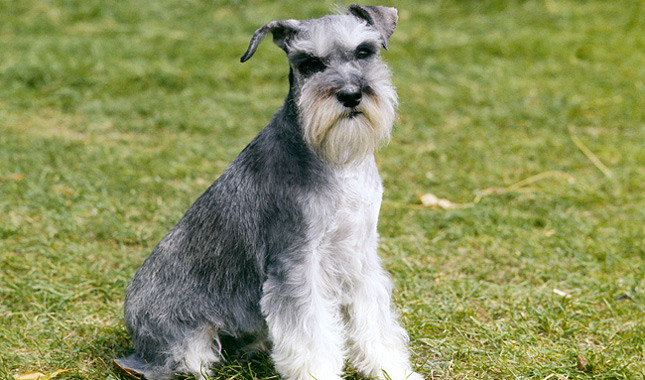

In [5]:
sample = Image.open("image_samples/Schnauzer.jpg")
sample

In [7]:
sample.size

(645, 380)

In [8]:
# validate
preprosessing = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
        ])

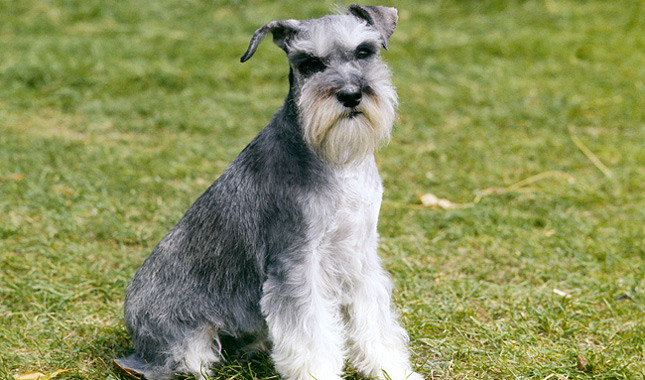

In [10]:
sample

In [11]:
preprocessed = preprosessing(sample)

In [13]:
model.eval()
pred = model(Variable(preprocessed.unsqueeze(0))) # 1,C,H,W 

In [14]:
for idx in pred.topk(5)[1].data.tolist()[0]: # Top 5 예측
    print(idx2cls[str(idx)])

miniature schnauzer
standard schnauzer
giant schnauzer
wire-haired fox terrier
Irish terrier


## Feature extractor 부분만 가져오기 

In [23]:
modules = list(model.children())[0]
feature_extractor = nn.Sequential(*modules)
feature_extractor

Sequential(
  (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (17): Conv2d (256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (18): ReLU(inplace)
  

## 파인튜닝 모델 

프리트레인드 모델을 특징 추출기로 사용

In [25]:
class CNN(nn.Module):
    
    def __init__(self,feature_extractor):
        super(CNN,self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = nn.Linear(512*7*7,2)
#         self.classifier = nn.Sequential(nn.Linear(512*7*7,512),
#                                                     nn.Dropout(0.3),
#                                                     nn.ReLU(),
#                                                     nn.Linear(512,256),
#                                                     nn.Dropout(0.3),
#                                                     nn.ReLU(),
#                                                     nn.Linear(256,2))
    def forward(self,inputs):
        
        features = self.feature_extractor(inputs)
        features = features.view(inputs.size(0),-1)
        
        return self.classifier(features)

In [26]:
model = CNN(feature_extractor)

In [27]:
model

CNN(
  (feature_extractor): Sequential(
    (0): Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (5): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (10): Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
    (17): Conv2d (256, 512, kernel_size

## Feature extractor의 parameter freeze

In [28]:
for module in list(model.children())[0]: # feature extractor의 weight는 고정
    print("fix weight", module)
    for param in module.parameters():
        param.requires_grad = False

fix weight Conv2d (3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
fix weight ReLU(inplace)
fix weight Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
fix weight ReLU(inplace)
fix weight MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
fix weight Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
fix weight ReLU(inplace)
fix weight Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
fix weight ReLU(inplace)
fix weight MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
fix weight Conv2d (128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
fix weight ReLU(inplace)
fix weight Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
fix weight ReLU(inplace)
fix weight Conv2d (256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
fix weight ReLU(inplace)
fix weight MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
fix weight Conv2d (256, 512, kernel_size=(3, 3), str

## Data pipeline 

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# train
train_dataset = vdatasets.ImageFolder(
        DATA_PATH+"cat_dog/train/",
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ]))

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=32, 
                                           shuffle=True,
                                           num_workers=2)


# train
test_dataset = vdatasets.ImageFolder(
        DATA_PATH+"cat_dog/dev/",
        transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ]))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=32, 
                                           shuffle=True,
                                           num_workers=2)

In [3]:
print(train_dataset.class_to_idx)
print(len(train_dataset.imgs))

{'cat': 0, 'dog': 1}
2000


## Fine Tuning(Train) 

In [11]:
EPOCH = 5
LR = 0.0001
loss_function = nn.CrossEntropyLoss()
if USE_CUDA:
    model = model.cuda()

# requires_grad가 True인 parameter만 update
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=LR)

In [12]:
model.train()
for epoch in range(EPOCH):
    losses=[]
    for i,(inputs,targets) in enumerate(train_loader):
        inputs, targets = Variable(inputs), Variable(targets)
        if USE_CUDA:
            inputs, targets = inputs.cuda(),targets.cuda()
        model.zero_grad()
        preds = model(inputs)
        loss = loss_function(preds,targets)
        losses.append(loss.data[0])
        loss.backward()
        optimizer.step()
    
    print("[%d/%d] mean_loss : %.3f" % (epoch,EPOCH,np.mean(losses)))

[0/5] mean_loss : 0.056
[1/5] mean_loss : 0.026
[2/5] mean_loss : 0.018
[3/5] mean_loss : 0.010
[4/5] mean_loss : 0.008


## Test 

In [13]:
model.eval()
num_equal=0
for i, (inputs, targets) in enumerate(test_loader):
    inputs, targets = Variable(inputs), Variable(targets)
    if USE_CUDA:
        inputs, targets = inputs.cuda(), targets.cuda()
    model.zero_grad()
    outputs = model(inputs)
    
    outputs = outputs.max(1)[1] # argmax
    num_equal += torch.eq(outputs,targets).sum().data[0]
    
    
print("Accuracy : " ,num_equal/len(test_dataset))

Accuracy :  0.9851970394078816
